In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [4]:
transform = transforms.ToTensor()

In [5]:
train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)

In [6]:
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform)

In [7]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [8]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [9]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [10]:
def show_digit_samples(digit, dataset):
    images = [img for img, label in dataset if label == digit][:5]
    fig, axs = plt.subplots(1, len(images))
    for i, img in enumerate(images):
        axs[i].imshow(img.squeeze(), cmap='gray')
        axs[i].axis('off')
    plt.show()

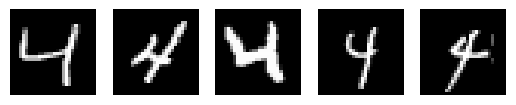

In [11]:
show_digit_samples(4,train_data)

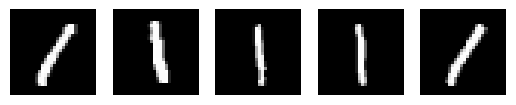

In [12]:
show_digit_samples(1,train_data)

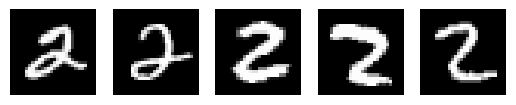

In [13]:
show_digit_samples(2,train_data)

In [14]:
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [15]:
for i, (X_Train, y_train) in enumerate(train_data):
  break

In [16]:
X_Train.shape

torch.Size([1, 28, 28])

In [17]:
x = X_Train.view(1,1,28,28)

In [18]:
x = F.relu(conv1(x))

In [19]:
x = F.max_pool2d(x,2,2)

In [20]:
x = F.relu(conv2(x))

In [21]:
x = F.max_pool2d(x,2,2)

In [22]:
x.shape

torch.Size([1, 16, 5, 5])

In [23]:
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2) 
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2) 
    X = X.view(-1, 16*5*5) 
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1)

In [24]:
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [27]:
epochs=10
train_losses=[]
test_losses=[]
train_correct=[]
test_correct=[]

for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  for b,(X_train, y_train) in enumerate(train_loader):
    b+=1 
    y_pred = model(X_train) 
    loss = criterion(y_pred, y_train) 

    predicted = torch.max(y_pred.data, 1)[1] 
    batch_corr = (predicted == y_train).sum()
    trn_corr += batch_corr 

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if b%600 == 0:
      print(f'Epoch: {i}  Batch: {b}  Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)

  with torch.no_grad():
      for b,(X_test, y_test) in enumerate(test_loader):
          y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] 
      tst_corr += (predicted == y_test).sum() 
      

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)

Epoch: 0  Batch: 600  Loss: 0.15794062614440918
Epoch: 1  Batch: 600  Loss: 0.09375838935375214
Epoch: 2  Batch: 600  Loss: 0.02847929857671261
Epoch: 3  Batch: 600  Loss: 0.010971885174512863
Epoch: 4  Batch: 600  Loss: 0.009145938791334629
Epoch: 5  Batch: 600  Loss: 0.04545392468571663
Epoch: 6  Batch: 600  Loss: 0.004391506779938936
Epoch: 7  Batch: 600  Loss: 0.14520691335201263
Epoch: 8  Batch: 600  Loss: 0.005604530684649944
Epoch: 9  Batch: 600  Loss: 0.00640549510717392


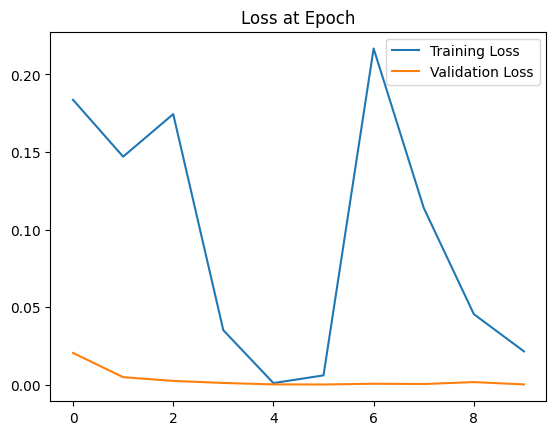

In [28]:
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss at Epoch")
plt.legend()

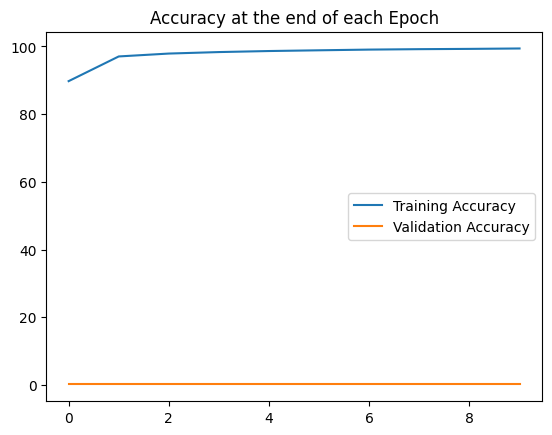

In [29]:
plt.plot([t/600 for t in train_correct], label="Training Accuracy")
plt.plot([t/100 for t in test_correct], label="Validation Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()

In [31]:
import seaborn as sns

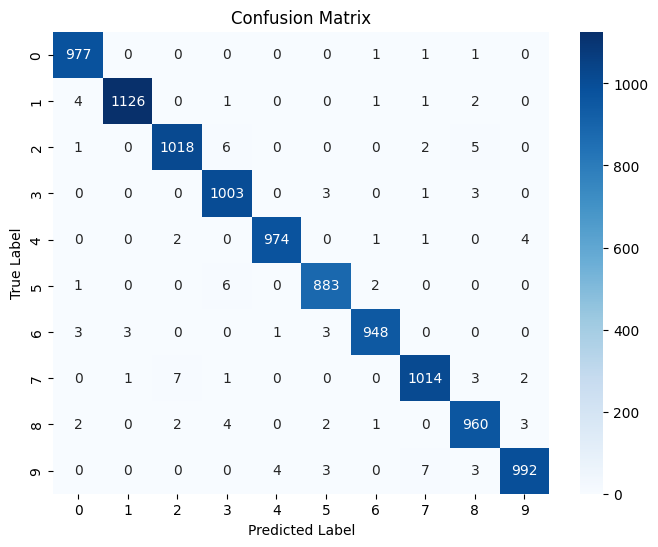

In [32]:
all_preds = []
all_labels = []
model.eval() 
with torch.no_grad():
    for X_test, y_test in test_loader:
        y_val = model(X_test)
        predicted = torch.max(y_val.data, 1)[1]
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_test.cpu().numpy())
cm = confusion_matrix(all_labels, all_preds)
class_names = [str(i) for i in range(len(cm))]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()